Python Notebook for creation of interactive sound recording
    Create and playback a personal recording
    Rewrite to same filename, ease of integration
    Display audio chart via librosa/matplotlib
    Use ML model to give output of gender and emotion
    

Move to 'live_guess.py'
    3 functions
        1.Record (button)
        2.Playback (button)
        3.Ouput (button) 
            label button as "Guess my Emotion"

In [1]:
#imports of libraries to use 'python sound device'
import sounddevice as sd
import soundfile as sf
import numpy as np
from scipy.io.wavfile import write

#import matplotlib for charting
import matplotlib.pyplot as plt

#import seaborn for chart formatting
import seaborn as sns

#import parselmouth for .wav sound file into chart
import parselmouth as PM

#import of librosa model/library
import librosa
import librosa.display

#other potentially useful/common libraries
import pandas as pd

In [3]:
#code chunk to record a numpy array .wav file, and save it
#save to same 'livefile.wav', avoids caching tons of files

fs = 44100 #sample rate
seconds = 5 #duration of recording

recording = sd.rec(int(seconds*fs), samplerate=fs, channels=2)
sd.wait() #waits until recording is finished, i.e 5 seconds
write('../livefile.wav', fs, recording) #saves as a WAV file

In [4]:
#code chunk to playback the live/recorded file
#essentially repeat of cell #3

file = "../livefile.wav"
data, fs = sf.read(file, dtype = 'float32')
sd.play(data, fs)
status = sd.wait()

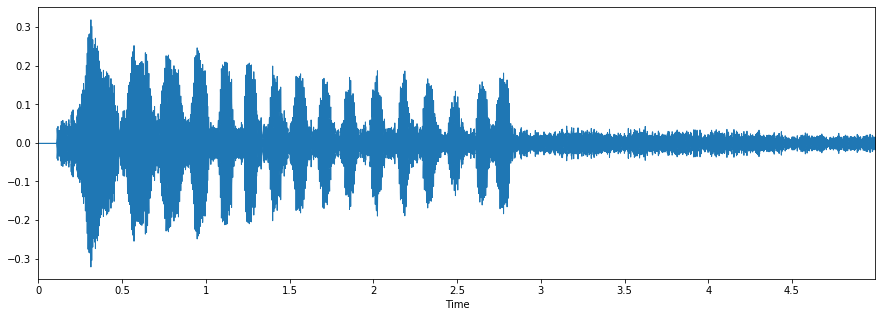

In [5]:
#use of librosa library to create another audio chart
data, sampling_rate = librosa.load("../livefile.wav")
plt.figure(figsize=(15,5))
librosa.display.waveplot(data, sr = sampling_rate)

#similar as before; create identical savefiles for overwriting/display
plt.savefig("live_librosa_chart.png")

In [6]:
#ML function imports

import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.models import model_from_json
from numpy import load

Using TensorFlow backend.


In [7]:
#create dataframe from librosa to create our features for ML
X, sample_rate = librosa.load('../livefile.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
live_mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
live_feature = live_mfccs
live = live_feature

live= pd.DataFrame(data=live)
live = live.stack().to_frame().T
live

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-12.219422,-13.365244,-11.289305,-10.838869,-11.988353,-11.759965,-10.992726,-12.294813,-10.725867,-10.526554,...,-20.907116,-21.51598,-19.488417,-19.313305,-18.627293,-18.24403,-18.498291,-16.955986,-15.831106,-15.919044


In [8]:
#loading previously trained model,
#and putting the new/live recording through

json_file = open('../model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("../saved_models/Emotion_Voice_Detection_Model.h5")

twodim= np.expand_dims(live, axis=2)

livepreds = loaded_model.predict(twodim, 
                        batch_size=32, 
                        verbose=1)

livepreds1=livepreds.argmax(axis=1)

liveabc = livepreds1.astype(int).flatten()
print(liveabc)
lb = LabelEncoder()
y_train=load('../y_train.npy',allow_pickle=True)
y_test=load('../y_test.npy',allow_pickle=True)
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))
livepredictions = str(lb.inverse_transform((liveabc))[0])
#gender=livepredictions[2:6]
#emotion=livepredictions[7:14]
gender_emotion = livepredictions.split('_')
gender=gender_emotion[0].capitalize()
emotion=gender_emotion[1].capitalize()
# print(livepredictions)
#return gender,emotion
print(gender, emotion)

1/1 [==============================] - 0s 76ms/step
[7]
Male Fearful


C:\Users\tbuhr\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
